In [1]:
from tqdm import tqdm
import random

In [2]:
import sys
import torch
import numpy as np
from torch.utils import data
from torch import nn
import pickle
from torch.nn import functional as F
from dataset import GTZAN
from datetime import datetime
from tqdm import tqdm
from torchmetrics import Accuracy
import matplotlib.pyplot as plt


DEBUG = True

dataset = GTZAN('/Users/zs18656/Documents/ADL DW COPY/data/train_trimmed.pkl')
dataset_val = GTZAN('/Users/zs18656/Documents/ADL DW COPY/data/val_trimmed.pkl')

In [3]:
N, N_val = len(dataset), len(dataset_val)
filename, spectrogram, label, samples = dataset[0]

In [4]:
class CNN(nn.Module):
    def __init__(self, height: int, width: int, channels: int, class_count: int):
        super().__init__()
        self.input_shape = (height, width, channels)
        self.class_count = class_count

        self.conv11 = nn.Conv2d(
            in_channels = self.input_shape[2], out_channels= 16, kernel_size=(10, 23),
            padding='same')
        self.conv12 = nn.Conv2d(
            in_channels= self.input_shape[2], out_channels= 16,kernel_size=(21, 20),
            padding= 'same')
        
        self.initialise_layer(self.conv11)
        self.pool11 = nn.MaxPool2d(kernel_size=(2, 2)) #Check stride
        self.initialise_layer(self.conv12)
        self.pool12 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.conv21 = nn.Conv2d(
            in_channels = 16, out_channels= 32, kernel_size=(5, 11),
            padding='same')
        self.conv22 = nn.Conv2d(
            in_channels= 16, out_channels= 32, kernel_size=(10, 5),
            padding= 'same')
        
        self.initialise_layer(self.conv21)
        self.pool21 = nn.MaxPool2d(kernel_size=(2, 2)) #Check stride
        self.initialise_layer(self.conv22)
        self.pool22 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.conv31 = nn.Conv2d(
            in_channels = 32, out_channels= 64, kernel_size=(3, 5),
            padding='same')
        self.conv32 = nn.Conv2d(
            in_channels= 32, out_channels= 64, kernel_size=(5, 3),
            padding= 'same')
        
        self.initialise_layer(self.conv31)
        self.pool31 = nn.MaxPool2d(kernel_size=(2, 2)) #Check stride
        self.initialise_layer(self.conv32)
        self.pool32 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.conv41 = nn.Conv2d(
            in_channels = 64, out_channels= 128, kernel_size=(2, 4),
            padding='same')
        self.conv42 = nn.Conv2d(
            in_channels= 64, out_channels= 128,kernel_size=(4, 2),
            padding= 'same')
        
        self.initialise_layer(self.conv41)
        self.pool41 = nn.MaxPool2d(kernel_size=(1, 5)) #Check stride
        self.initialise_layer(self.conv42)
        self.pool42 = nn.MaxPool2d(kernel_size=(5, 1))
        
        self.fc1 = nn.Linear(5120, 200)
        self.initialise_layer(self.fc1)
        self.fc2 = nn.Linear(200, 10)
        self.initialise_layer(self.fc2)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        x_left, x_right = F.relu(self.conv11(images)), F.relu(self.conv12(images))
        x_left, x_right = self.pool11(x_left), self.pool12(x_right)
         
        x_left, x_right = F.relu(self.conv21(x_left)), F.relu(self.conv22(x_right))         
        x_left, x_right = self.pool21(x_left), self.pool22(x_right)

        x_left, x_right = F.relu(self.conv31(x_left)), F.relu(self.conv32(x_right))
        x_left, x_right = self.pool31(x_left), self.pool32(x_right)
         
        x_left, x_right = F.relu(self.conv41(x_left)), F.relu(self.conv42(x_right))
        x_left, x_right = self.pool41(x_left), self.pool42(x_right)
         
        x_left = torch.flatten(x_left, start_dim = 1)
        x_left = torch.flatten(x_left)
        
        x_right = torch.flatten(x_right, start_dim = 1)
        x_right = torch.flatten(x_right)
        
        x_conc = torch.cat((x_left, x_right))
        x_conc = F.relu(self.fc1(x_conc))
        x_conc = self.fc2(x_conc)
        return x_conc

    @staticmethod
    def initialise_layer(layer):
        if hasattr(layer, "bias"):
            nn.init.zeros_(layer.bias)
        if hasattr(layer, "weight"):
            nn.init.kaiming_normal_(layer.weight)
            
def get_batch_ids(N, batch_size):
    sample_ids = np.arange(N)
    random.shuffle(sample_ids)
    num_batchs = N/batch_size

    sampled_n = 0
    batch_ids = []
    for batch in range(int(num_batchs)):
        batch_i = sample_ids[batch*batch_size:(batch+1)*batch_size]
        sampled_n += batch_size
        batch_ids.append(batch_i)
    if num_batchs != int(num_batchs):
        batch_i = (sample_ids[sampled_n:])
        batch_ids.append(batch_i)
    return batch_ids

In [5]:
print('Training Data Size: ', N)
print('Testing Data Size: ', N_val)

Training Data Size:  200
Testing Data Size:  100


In [6]:
model = CNN(height=80, width=80, channels=1, class_count=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, betas=(0.9, 0.999), eps=1e-08)
losses, losses_val = [], []
n_classes = 10
epoch_N = 300
batch_size = 50

In [7]:
losses, val_losses = [], []
epoch_preds, val_preds = [], []
epoch_trues = []

for epoch in tqdm(range(epoch_N)):
#     TRAINING DATA EVALUATION + TRAINING
#     epoch_loss = 0
    class_preds, class_trues = [], []
    
    for batch_ids in get_batch_ids(N, batch_size):
        batch_loss = 0
        for i in batch_ids:
            label_i_tensor = torch.zeros(n_classes)
            filename_i, spectrogram_i, label_i, samples_i = dataset[i]
            label_i_tensor[label_i] = 1
            pred = model.forward(spectrogram_i)
            batch_loss += criterion(pred, label_i_tensor)

            class_preds.append(torch.argmax(pred))
            class_trues.append(label_i)

        batch_loss.backward()
        # update weights
        optimizer.step()
        # zero gradients
        optimizer.zero_grad()
        losses.append(batch_loss)
    epoch_preds.append(class_preds)
    epoch_trues.append(class_trues)
    
#     VALIDATION DATA EVALUATION
    val_loss = 0
    class_preds, val_trues = [], []
    for i in range(N_val):
        label_i_tensor = torch.zeros(n_classes)
        filename_i, spectrogram_i, label_i, samples_i = dataset_val[i]
        label_i_tensor[label_i] = 1
        with torch.no_grad():
            pred = model.forward(spectrogram_i)
        val_loss += criterion(pred, label_i_tensor)
        
        class_preds.append(torch.argmax(pred))
        val_trues.append(label_i)
        
    val_losses.append(val_loss)
    val_preds.append(class_preds)

  0%|                                                   | 0/300 [00:00<?, ?it/s]/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
100%|█████████████████████████████████████████| 300/300 [54:12<00:00, 10.84s/it]


final train loss:  0.060085185
final test loss:  993.0132


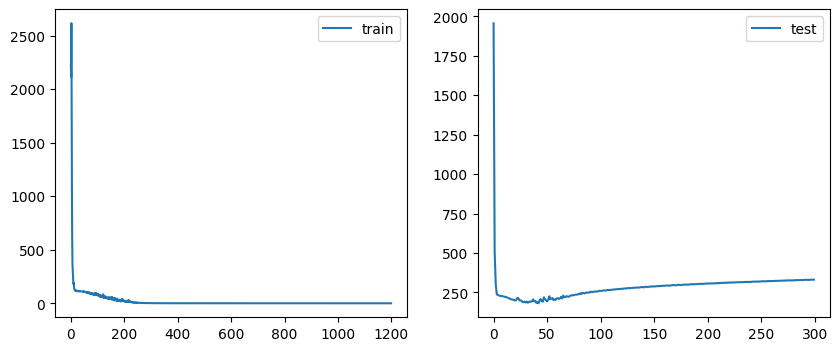

In [8]:
TC_loss_tr, TC_loss_te = [], []
for i in losses:
    TC_loss_tr.append(i.detach().numpy())
for i in val_losses:
    TC_loss_te.append(i.detach().numpy())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot((TC_loss_tr), label = 'train')
axes[1].plot((TC_loss_te), label = 'test')
axes[0].legend()
axes[1].legend()

n_batchs = int(N/batch_size)
print('final train loss: ', np.sum(TC_loss_tr[-n_batchs:-1]))
print('final test loss: ', np.sum(TC_loss_te[-n_batchs:-1]))

In [9]:
epoch_accs = []
for epoch in range(epoch_N):
    hits = 0
    for i in range(N):
        pred_i = epoch_preds[epoch][i].numpy()
        true_i = epoch_trues[epoch][i]
        if int(pred_i) == int(true_i):
            hits += 1
    epoch_accs.append(hits/N)

val_accs = []
for epoch in range(epoch_N):
    hits = 0
    for i in range(N_val):
        pred_i = val_preds[epoch][i].numpy()
        if pred_i == val_trues[i]:
            hits += 1
#             print(hits)
    val_accs.append(hits/N_val)

Train Acc:  1.0
Test Acc:  0.38


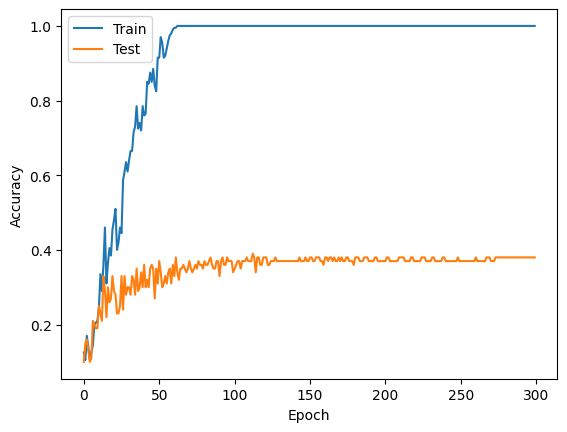

In [10]:
plt.plot(epoch_accs, label = 'Train')
plt.plot(val_accs, label = 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
print('Train Acc: ', epoch_accs[-1])
print('Test Acc: ', val_accs[-1])

In [ ]:
# losses, val_losses = [], []
# epoch_preds, val_preds = [], []

# for epoch in tqdm(range(epoch_N)):
# #     TRAINING DATA EVALUATION + TRAINING
#     epoch_loss = 0
#     class_preds, class_trues = [], []
    
#     for i in range(N):
#         label_i_tensor = torch.zeros(n_classes)
#         filename_i, spectrogram_i, label_i, samples_i = dataset[i]
#         label_i_tensor[label_i] = 1
#         pred = model.forward(spectrogram_i)
#         epoch_loss += criterion(pred, label_i_tensor)
        
#         class_preds.append(torch.argmax(pred))
#         class_trues.append(label_i)

#     epoch_loss.backward()
#     # update weights
#     optimizer.step()
#     # zero gradients
#     optimizer.zero_grad()
#     losses.append(epoch_loss)
#     epoch_preds.append(class_preds)
    
# #     VALIDATION DATA EVALUATION
#     val_loss = 0
#     class_preds, val_trues = [], []
#     for i in range(N_val):
#         label_i_tensor = torch.zeros(n_classes)
#         filename_i, spectrogram_i, label_i, samples_i = dataset_val[i]
#         label_i_tensor[label_i] = 1
#         with torch.no_grad():
#             pred = model.forward(spectrogram_i)
#         val_loss += criterion(pred, label_i_tensor)
        
#         class_preds.append(torch.argmax(pred))
#         val_trues.append(label_i)
        
#     val_losses.append(val_loss)
#     val_preds.append(class_preds)